In [1]:
from alntk.alignment import Alignment, filter_residues_any, filter_residue, filter_length, filter_ambiguous, write_to_fasta
from alntk.plotting import default_plot_style, plot_length_distrib

In [2]:
data_folder = '../data/'
color_cycle = default_plot_style()

# Cleaning of the alignment

*Written by Shoichi Yip. Last updated: 13 December 2024.*

In this notebook we will clean the alignment contained in the file `new_aln0.faa`, contained in the `data` folder.

The `new_aln0.faa` file is the result of the following operations:

1. We made an HMM profile using the 1470 sequences of the `s1Ahalabi_1470.an` file.
2. We used this HMM profile and matched it against the UniProt database using `hmmsearch`. The output is in `stk` format.
3. We get rid of the informations we do not need and produce a FASTA file of the alignment `new_aln0.faa`.

The `s1Ahalabi_1470.an` file is a manually curated alignment made by Najeeb Halabi for the [Halabi 2009 paper](https://doi.org/10.1016/j.cell.2009.07.038). It contains 1470 sequences representatives of the S1A Serine Protease family.

Now we want to further preprocess this alignment:

1. We want to filter out sequences that contain ambiguous symbols.
2. We want to filter out sequences that do not have residues in the `IVGG` positions of the Rat Trypsin. We also want to get rid of the positions before the `IVGG` pattern in Rat Trypsin.
3. We want to filter the sequences by length.

The output will be written in a `new_aln.faa` file in the `data` folder.

## Importing the original alignment

In [3]:
aln = Alignment()
aln.import_from_fasta(data_folder + 'new_aln0.faa')
aln.print_report()

Number of sequences: 189304
Number of positions: 823


The original alignment has **189304 sequences** and **823 positions**.

## Filter out sequences with ambiguous symbols

Protein databases such as UniProt contain sequences that have twenty amino acid symbols.

```
A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y
```

Then the **gap symbol** `-` is used as well as a consequence of the alignment.
Moreover there are four **ambiguous symbols**, which are non-standard symbols which intended use is for ambiguity between two amino acids.

```
B, J, X, Z
```

Sequences containing ambiguous symbols do not constitute the bulk of the sequences and make the data harder to deal with (e.g. adding more columns to arrays) and do not contribute enough to the statistics to be relevant for model training.

We will hence filter out **sequences containing ambiguous symbols**.

In [4]:
aln_filter = filter_ambiguous(aln)
aln.drop(aln_filter)
aln.print_report()

Number of sequences: 187691
Number of positions: 823


## Filter out sequences that do not have residues in the `IVGG` positions of the Rat Trypsin and positions before the `IVGG` pattern

Serine proteases present themselves as **zymogens**. This means that as found in databases such as UniProt, they present themselves in the guise precursors of the actual enzymes, having two additional pieces of sequence at the N-terminus of the protein (i.e. at the beginning of the sequence, since we read protein sequences from the N-terminus to the C-terminus).

For example, in the following we can see the N-terminus of the Rat Trypsin (`TRY2_RAT`) sequence.

```
1       5         10          15        20          25
M R A L L F L A L V G A A V * A F P V D D D D K * I V G G Y ...
```

Residues 1 to 14 constitute a part called **signal peptide**. This part of the zymogen helps the secretion of the enzyme in extracellular matrix. Once it is secreted the part before the first asterisk is cleaved off.

Residues 15 to 23 constitue a part called **activation peptide**. Upon secretion in fact the enzyme is still inactive. It becomes active as soon as the part before the second asterisk is cleaved off.

We will filter out:

- the **columns** before any occurence of the `IVGG` pattern in Rat Trypsin, that is called `TRY2_RAT` in UniProt
- The **sequences** that have gaps in any of these four columns

In [5]:
aln_filter = filter_residues_any(aln, 'TRY2_RAT', 'IVGG')
aln.drop(aln_filter)
aln.print_report()

Number of sequences: 126548
Number of positions: 693


We are left with **126 548 sequences** and **693 positions**.

## Filter sequences by presence of catalytic serine (NOT DONE)

The family of Serine Protease is characterised by the presence of the **catalytic serine**, which is the key residue that enables the hydrolysis of the peptide bond in the substrate. In the numbering of residues given by Bovine Chymotrypsin this residue is labeled **Ser195**, meaning the serine in position 195.

A manual inspection will yield that the catalytic serine is found at the beginning of the `SG-GPV` pattern. Let's filter sequences by this criterion.

This part has been eliminated in the alignment to take account of members that have lost activity. However when we synthesise sequences we should select onl

In [6]:
# aln_filter = filter_residue(aln, 'TRY2_RAT', 'SG-GPV', 'S')
# aln.drop(aln_filter)
aln.print_report()

Number of sequences: 126548
Number of positions: 693


We are left with **126 548 sequences** and **693 positions**.

## Filter sequences by length

Let us check the length of sequences without gaps.

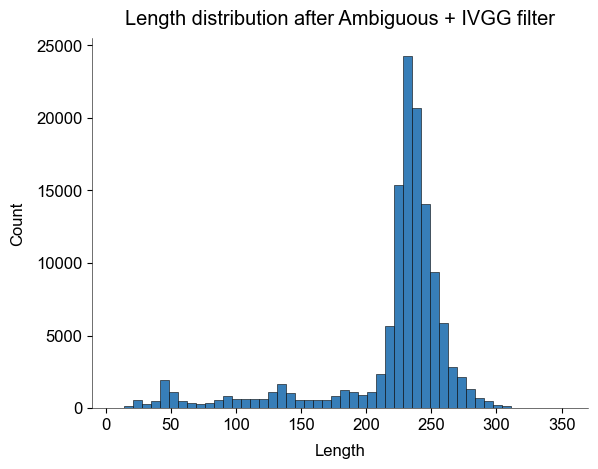

In [7]:
fig = plot_length_distrib(aln, 'Length distribution after Ambiguous + IVGG filter')

We can see that the bulk of the alignment can be found in a mode approximately between 200 residues and 270 residues.

We filter out all other sequences.

In [8]:
aln_filter = filter_length(aln, 200, 270)
aln.drop(aln_filter)
aln.print_report()

Number of sequences: 101543
Number of positions: 693


We are left with **101 543 sequences**, and we have the following length distribution.

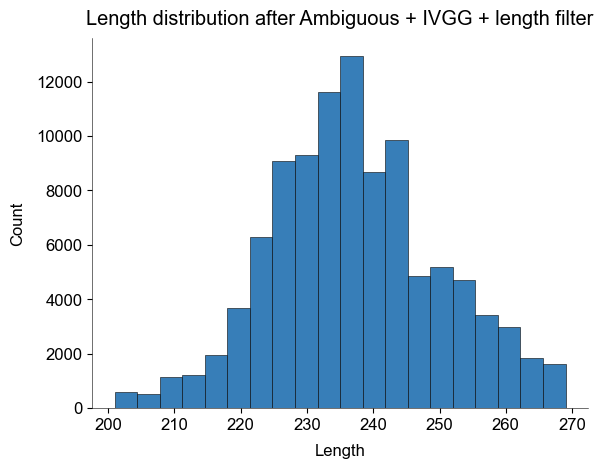

In [9]:
fig = plot_length_distrib(aln, 'Length distribution after Ambiguous + IVGG + length filter', 20)

## Saving the cleaned alignment to a new file

We now save the current alignment to a new file `new_aln.faa` in the `data` folder.

The new alignment has **101 543 sequences** and **693 positions**, meaning that we got rid of 82 747 sequences and 130 positions.

In [10]:
write_to_fasta(aln, data_folder + 'new_aln.faa')